# Tracing Nhamini-wi — In Search of the Lost Path

- **Project:** Tracing Nhamini-wi — In Search of the Lost Path
- **Author:** Giovanni Cocco
- **Date:** June, 2025

## Index
- [Introduction](#introduction-tracing-nhamini-wi--in-search-of-the-lost-path)
- [Benchmark: Establishing a Baseline in the Unknown](#benchmark-establishing-a-baseline-in-the-unknown)
- [Google Earth Engine Authentication](#google-earth-engine-authentication)
- [From Data to Discovery](#from-data-to-discovery)
- [Sensing the Unknown](#sensing-the-unknown)
- [Comparing Legends and Landmarks](#comparing-legends-and-landmarks)
- [AI Assessment: Insights from the Digital Expedition](#ai-assessment-insights-from-the-digital-expedition)
- [Seeing the Unseen: Visualizing the Candidate Site](#seeing-the-unseen-visualizing-the-candidate-site)
- [Leveraging Candidate Analysis for Future Discoveries](#leveraging-candidate-analysis-for-future-discoveries)
- [Project Structure](#project-structure)
- [Methodology](#methodology)
- [Knowing Issues](#issues)

Every legend begins with a mystery. Deep in the tangled forests of northwestern Amazonia, the trail of Nhamini-wi lingers—an ancient route that echoes through Indigenous memory and the journals of explorers who dared to cross these lands. Some say it was a road paved with stone, others whisper of geometric earthworks and signs of vanished civilizations.

Guided by these tales, I set out not with a machete, but with code and curiosity. My expedition would not fight vines or wild rivers, but data: petabytes of open-source satellite imagery, remote sensing indices, and the pattern-finding powers of modern AI. Somewhere within these swirling pixels, I hoped, traces of the lost path might reveal themselves.

I focused my digital search on the Brazilian Amazon near the headwaters of the Içana and Uaupés, ever watchful for clues crossing the invisible frontiers into Colombia and Venezuela. This journey isn’t only about data—it’s about making the invisible visible again, about uncovering forgotten stories written on the land itself.

## Benchmark: Establishing a Baseline in the Unknown

Every explorer needs a compass. Before venturing into the unmapped, I needed to calibrate my digital senses—to distinguish the unusual from the expected. I turned to Acre, a region where decades of fieldwork have already uncovered monumental geoglyphs and ancient sites. These known locations would serve as my reference points, my “control group” in the jungle.

Armed with AI, I asked for coordinates of these archaeological benchmarks. Their signatures in the data—NDVI, SRTM, radar, land cover—would help me recognize what a true anomaly might look like deeper in the unknown.

In [2]:
# benchmark.py

from kaggle_secrets import UserSecretsClient
from openai import OpenAI
from pydantic import BaseModel
import pandas as pd

# Load OpenAI API key from Kaggle secrets or environment
try:
    user_secrets = UserSecretsClient()
    openai_key = user_secrets.get_secret("openai")
except Exception:
    import os
    openai_key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key) if openai_key else OpenAI()

# Define Pydantic models for structured output
class BenchmarkSite(BaseModel):
    name: str
    lat: float
    lon: float

class BenchmarkSites(BaseModel):
    sites: list[BenchmarkSite]

# Prompt for OpenAI Structured Output (expects a JSON object with a 'sites' key)
prompt = (
    "You are an archaeologist specialized in the Amazon region.\n"
    "List at least 10 known archaeological sites located in the state of Acre, Brazil, "
    "including their approximate latitude and longitude.\n"
    "Return ONLY a JSON object with a 'sites' key, which is a list of objects with fields: name (string), lat (number), lon (number).\n"
    "Example: {\"sites\": [{\"name\": \"Site Name\", \"lat\": -X.XXXX, \"lon\": -Y.YYYY}]}\n"
    "Focus on geoglyphs and earthworks documented in academic literature or official records.\n"
)

# Call OpenAI API and parse with Pydantic Structured Output
response = client.responses.parse(
    model="o3",
    input=[{"role": "user", "content": prompt}],
    text_format=BenchmarkSites,
)

sites = response.output_parsed.sites
df_benchmark = pd.DataFrame([s.model_dump() for s in sites])

# Add Google Maps column before display
def make_gmaps_link(lat, lon):
    url = f'https://www.google.com/maps/search/?api=1&query={lat},{lon}'
    return f'<a href="{url}" target="_blank">View on Google Maps</a>'

df_benchmark['Google Maps'] = df_benchmark.apply(lambda row: make_gmaps_link(row['lat'], row['lon']), axis=1)

# Display DataFrame in notebook/Kaggle environment, fallback to print
try:
    from IPython.display import display, HTML
    display(HTML(df_benchmark.to_html(escape=False)))
except Exception:
    print(df_benchmark)

# Print model version used
print(f"\n[INFO] OpenAI model used: o3")

# Print token usage if available
usage = getattr(response, "usage", None)
if usage:
    print(f"\nPrompt tokens: {getattr(usage, 'prompt_tokens', getattr(usage, 'input_tokens', None))}")
    print(f"Completion tokens: {getattr(usage, 'completion_tokens', getattr(usage, 'output_tokens', None))}")
    print(f"Total tokens: {getattr(usage, 'total_tokens', None)}")

,name,lat,lon,Google Maps
0,Fazenda Colorada Geoglyph,-10.1667,-67.5167,View on Google Maps
1,Sol de Campinas (Sun of Campinas) Geoglyph,-10.0500,-67.2500,View on Google Maps
2,Jacó Sá Geoglyph,-9.9330,-67.4170,View on Google Maps
3,Bela Vista Geoglyph,-10.5953,-67.0053,View on Google Maps
4,Periquito Geoglyph,-10.5836,-67.0186,View on Google Maps
5,Tequinho (Fazenda do Tequinho) Geoglyph,-9.1417,-68.1992,View on Google Maps
6,Fazenda São Francisco Geoglyph,-9.9689,-66.8778,View on Google Maps
7,Antimary Earthwork Complex,-9.9917,-67.9228,View on Google Maps
8,Vila Rubim Geoglyph,-10.7481,-68.3900,View on Google Maps
9,Fazenda Paraná (Paraná do Ouro) Geoglyph,-10.2556,-67.1403,View on Google Maps



[INFO] OpenAI model used: o3

Prompt tokens: 215
Completion tokens: 1435
Total tokens: 1650


### Google Earth Engine Authentication
Before retrieving sensor parameters, authenticate with Google Earth Engine running the code below:

In [3]:
# auth.py

from kaggle_secrets import UserSecretsClient
import json
import ee

# Get the Service Account key from Kaggle Secrets
user_secrets = UserSecretsClient()
gcloud_key = user_secrets.get_secret("service_account")  # or the secret name you used

# Save the key to a file (Earth Engine expects a file)
with open('gcloud_key.json', 'w') as f:
    f.write(gcloud_key)

# Load the service account email
service_account_info = json.loads(gcloud_key)
service_account = service_account_info['client_email']

# Authenticate Earth Engine with the service account
credentials = ee.ServiceAccountCredentials(service_account, 'gcloud_key.json')
ee.Initialize(credentials)

With authentication in place, I can now programmatically retrieve a rich suite of environmental parameters for each benchmark site. These include NDVI (vegetation index), NDWI (surface water), NDBI (bare soil and built-up areas), SRTM elevation, terrain slope, Sentinel-1 radar backscatter (VV and VH polarizations), MapBiomas land cover classification, and GEDI-derived canopy height where available. This multi-sensor approach allows for a more nuanced characterization of each site and provides a robust reference framework for detecting potential anomalies across the Amazon.

In [9]:
#get-benchmark-data.py

# --- DATASET IDS USED ---
DATASET_IDS = [
    'COPERNICUS/S2_SR_HARMONIZED',
    'COPERNICUS/S1_GRD',
    'USGS/SRTMGL1_003',
    'projects/mapbiomas-raisg/public/collection3/mapbiomas_raisg_panamazonia_collection3_integration_v2',
    'LARSE/GEDI/GEDI02_A_002_MONTHLY',
    'NASA/JPL/global_forest_canopy_height_2005'
]

print("[INFO] Datasets used in this script:")
for ds in DATASET_IDS:
    print(f"  - {ds}")
print()

# --- Earth Engine functions ---
# --- Authenticate with Earth Engine before running this block ---

import ee
import pandas as pd
import time

# --- Earth Engine functions ---

def get_ndvi(lat, lon, year=2023, buffer_m=50):
    point = ee.Geometry.Point([lon, lat]).buffer(buffer_m)
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(point)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)))
    # Get the least cloudy image
    s2_sorted = s2.sort('CLOUDY_PIXEL_PERCENTAGE')
    img = ee.Image(s2_sorted.first())
    ndvi_img = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndvi = ndvi_img.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point, scale=10).get('NDVI')
    # Get the image ID
    img_id = img.get('PRODUCT_ID')
    if img_id is None:
        img_id = img.get('system:index')
    return {
        'ndvi': ndvi.getInfo() if ndvi is not None else None,
        'sentinel2_id': img_id.getInfo() if img_id is not None else None
    }

def get_ndwi(lat, lon, year=2023, buffer_m=50):
    point = ee.Geometry.Point([lon, lat]).buffer(buffer_m)
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(point)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(lambda img: img.normalizedDifference(['B3', 'B8']).rename('NDWI')))
    ndwi = s2.median().select('NDWI').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point, scale=10).get('NDWI')
    return ndwi.getInfo() if ndwi is not None else None

def get_ndbi(lat, lon, year=2023, buffer_m=50):
    point = ee.Geometry.Point([lon, lat]).buffer(buffer_m)
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(point)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(lambda img: img.normalizedDifference(['B11', 'B8']).rename('NDBI')))
    ndbi = s2.median().select('NDBI').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point, scale=10).get('NDBI')
    return ndbi.getInfo() if ndbi is not None else None

def get_srtm_elevation(lat, lon, buffer_m=50):
    point = ee.Geometry.Point([lon, lat]).buffer(buffer_m)
    srtm = ee.Image("USGS/SRTMGL1_003")
    elev = srtm.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point, scale=30).get('elevation')
    return elev.getInfo() if elev is not None else None

def get_srtm_slope(lat, lon, buffer_m=50):
    point = ee.Geometry.Point([lon, lat]).buffer(buffer_m)
    elev = ee.Image("USGS/SRTMGL1_003")
    slope = ee.Terrain.slope(elev)
    slope_val = slope.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point, scale=30).get('slope')
    return slope_val.getInfo() if slope_val is not None else None

def get_sentinel1_vv(lat, lon, year=2023, buffer_m=1000):
    """
    Returns the average VV backscatter of Sentinel-1.
    
    buffer_m = 1000 by default (>> 50 m from other sensors)
    ──────────────────────────────────────────────────────────
    Using a larger buffer reduces the speckle noise characteristic
    of radar images when spatially averaging. 
    """
    try:
        point = ee.Geometry.Point(lon, lat)
        roi = point.buffer(buffer_m).bounds()
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterBounds(roi) \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .select('VV')
        count = s1.size().getInfo()
        if count == 0:
            return {'vv': None, 'sentinel1_id': None}
        s1_img = s1.median()
        vv_value = s1_img.reduceRegion(ee.Reducer.mean(), point, 30).get('VV')
        # Get scene ID from first image
        first_img = ee.Image(s1.first())
        img_id = first_img.get('system:index')
        return {
            'vv': vv_value.getInfo() if vv_value is not None else None,
            'sentinel1_id': img_id.getInfo() if img_id is not None else None
        }
    except Exception as e:
        print(f"Sentinel-1 VV error at ({lat}, {lon}): {e}")
        return {'vv': None, 'sentinel1_id': None}

def get_sentinel1_vh(lat, lon, year=2023, buffer_m=1000):
    """
    Returns the average VH backscatter from Sentinel-1.
    
    The 1000m buffer helps to smooth out radar speckle.
    """
    try:
        point = ee.Geometry.Point(lon, lat)
        roi = point.buffer(buffer_m).bounds()
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterBounds(roi) \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .select('VH')
        count = s1.size().getInfo()
        if count == 0:
            return None
        s1_img = s1.median()
        vh_value = s1_img.reduceRegion(ee.Reducer.mean(), point, 30).get('VH')
        return vh_value.getInfo() if vh_value is not None else None
    except Exception as e:
        print(f"Sentinel-1 VH error at ({lat}, {lon}): {e}")
        return None

def get_mapbiomas_class(lat, lon, year=2020):
    try:
        point = ee.Geometry.Point(lon, lat)
        img = ee.Image('projects/mapbiomas-raisg/public/collection3/mapbiomas_raisg_panamazonia_collection3_integration_v2') \
            .select(f'classification_{year}')
        value = img.reduceRegion(ee.Reducer.mode(), point, 30).get(f'classification_{year}')
        return value.getInfo() if value is not None else None
    except Exception as e:
        print(f"MapBiomas error at ({lat}, {lon}): {e}")
        return None


def get_gedi_canopy_height(lat, lon):
    """
    Returns mean GEDI canopy height (rh98) for a point.
    If GEDI is not available, fallback to NASA/JPL/global_forest_canopy_height_2005.
    """
    try:
        point = ee.Geometry.Point([lon, lat])
        gedi = (ee.ImageCollection('LARSE/GEDI/GEDI02_A_002_MONTHLY')
                .filterBounds(point))
        if gedi.size().getInfo() == 0:
            raise ValueError("No GEDI pulses")
        gedi_img = gedi.select('rh98').median()
        value = gedi_img.reduceRegion(
            ee.Reducer.mean(), point, 25).get('rh98')
        val = value.getInfo() if value is not None else None
        if val is not None and val != 0:
            return val
        # If value is None or 0, fallback
        raise ValueError("GEDI returned None or 0")
    except Exception as e:
        print(f"GEDI error at ({lat}, {lon}): {e}. Trying NASA/JPL/global_forest_canopy_height_2005...")
        try:
            # NASA/JPL/global_forest_canopy_height_2005: altura média do dossel em metros (2005)
            point = ee.Geometry.Point([lon, lat])
            canopy_img = ee.Image('NASA/JPL/global_forest_canopy_height_2005')
            value = canopy_img.reduceRegion(
                ee.Reducer.mean(), point, 1000).get('1')
            val = value.getInfo() if value is not None else None
            return val
        except Exception as e2:
            print(f"Fallback canopy height error at ({lat}, {lon}): {e2}")
            return None

# --- Enrich DataFrame with all sensors ---

def enrich_benchmarks_with_all_sensors(
    df,
    ndvi_year=2023,
    ndwi_year=2023,
    ndbi_year=2023,
    s1_year=2023,
    mapbiomas_year=2020,
    buffer_m=50,
    delay=1
):
    ndvi_list = []
    s2_id_list = []
    ndwi_list = []
    ndbi_list = []
    elev_list = []
    slope_list = []
    vv_list = []
    s1_id_list = []
    vh_list = []
    landclass_list = []
    canopyheight_list = []

    for idx, row in df.iterrows():
        lat, lon = row['lat'], row['lon']
        print(f"Processing {row.get('name', 'site')} ({lat}, {lon})...")
        
        # Get NDVI and Sentinel-2 ID
        ndvi_result = get_ndvi(lat, lon, ndvi_year, buffer_m)
        if isinstance(ndvi_result, dict):
            ndvi_list.append(ndvi_result['ndvi'])
            s2_id_list.append(ndvi_result['sentinel2_id'])
        else:
            ndvi_list.append(ndvi_result)
            s2_id_list.append(None)
        
        ndwi_list.append(get_ndwi(lat, lon, ndwi_year, buffer_m))
        ndbi_list.append(get_ndbi(lat, lon, ndbi_year, buffer_m))
        elev_list.append(get_srtm_elevation(lat, lon, buffer_m))
        slope_list.append(get_srtm_slope(lat, lon, buffer_m))
        
        # Get Sentinel-1 VV and ID
        s1_vv_result = get_sentinel1_vv(lat, lon, s1_year, buffer_m=1000)
        if isinstance(s1_vv_result, dict):
            vv_list.append(s1_vv_result['vv'])
            s1_id_list.append(s1_vv_result['sentinel1_id'])
        else:
            vv_list.append(s1_vv_result)
            s1_id_list.append(None)
        
        vh_list.append(get_sentinel1_vh(lat, lon, s1_year, buffer_m=1000))
        landclass_list.append(get_mapbiomas_class(lat, lon, mapbiomas_year))
        canopyheight_list.append(get_gedi_canopy_height(lat, lon))
        time.sleep(delay)  # To avoid quota limits

    df['NDVI'] = ndvi_list
    df['Sentinel2_ID'] = s2_id_list
    df['NDWI'] = ndwi_list
    df['NDBI'] = ndbi_list
    df['Elevation'] = elev_list
    df['Slope'] = slope_list
    df['Sentinel1_VV'] = vv_list
    df['Sentinel1_ID'] = s1_id_list
    df['Sentinel1_VH'] = vh_list
    df['MapBiomas_Class'] = landclass_list
    df['CanopyHeight'] = canopyheight_list
    return df

# --- Usage example ---

# df_benchmark = pd.read_csv("benchmark_sites_acre.csv")  # or from previous cell
df_benchmark = enrich_benchmarks_with_all_sensors(df_benchmark)

# Remove 'Google Maps' column if present (inherited from other scripts)
if 'Google Maps' in df_benchmark.columns:
    df_benchmark.drop(columns=['Google Maps'], inplace=True)
# Keep 'Sentinel2_ID' and 'Sentinel1_ID' columns - only these sensors have individual scene IDs
# Other sensors (SRTM, MapBiomas, GEDI, NASA/JPL) are static/aggregated datasets without individual scene IDs

# Substitui infinitos por NaN para evitar warnings do pandas
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
df_benchmark.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the main DataFrame with scene IDs included
from IPython.display import display
display(df_benchmark)

[INFO] Datasets used in this script:
  - COPERNICUS/S2_SR_HARMONIZED
  - COPERNICUS/S1_GRD
  - USGS/SRTMGL1_003
  - projects/mapbiomas-raisg/public/collection3/mapbiomas_raisg_panamazonia_collection3_integration_v2
  - LARSE/GEDI/GEDI02_A_002_MONTHLY
  - NASA/JPL/global_forest_canopy_height_2005

Processing Fazenda Colorada Geoglyph (-10.1667, -67.5167)...
GEDI error at (-10.1667, -67.5167): GEDI returned None or 0. Trying NASA/JPL/global_forest_canopy_height_2005...
Processing Sol de Campinas (Sun of Campinas) Geoglyph (-10.05, -67.25)...
GEDI error at (-10.05, -67.25): GEDI returned None or 0. Trying NASA/JPL/global_forest_canopy_height_2005...
Processing Jacó Sá Geoglyph (-9.933, -67.417)...
GEDI error at (-9.933, -67.417): GEDI returned None or 0. Trying NASA/JPL/global_forest_canopy_height_2005...
Processing Bela Vista Geoglyph (-10.5953, -67.0053)...
GEDI error at (-10.5953, -67.0053): GEDI returned None or 0. Trying NASA/JPL/global_forest_canopy_height_2005...
Processing Periqui

,name,lat,lon,NDVI,Sentinel2_ID,NDWI,NDBI,Elevation,Slope,Sentinel1_VV,Sentinel1_ID,Sentinel1_VH,MapBiomas_Class,CanopyHeight
0,Fazenda Colorada Geoglyph,-10.1667,-67.5167,0.676380,S2B_MSIL2A_20230725T144729_N0509_R139_T19LFJ_2...,-0.654691,-0.118831,183.579206,4.423710,-8.389500,S1A_IW_GRDH_1SDV_20230107T100625_20230107T1006...,-14.895126,14,13
1,Sol de Campinas (Sun of Campinas) Geoglyph,-10.0500,-67.2500,0.789271,S2B_MSIL2A_20230725T144729_N0509_R139_T19LFJ_2...,-0.713925,-0.277626,193.232975,7.561780,-7.300769,S1A_IW_GRDH_1SDV_20230107T100625_20230107T1006...,-12.873268,3,21
2,Jacó Sá Geoglyph,-9.9330,-67.4170,0.801855,S2B_MSIL2A_20230725T144729_N0509_R139_T19LFK_2...,-0.718250,-0.297136,160.641095,3.419527,-9.336549,S1A_IW_GRDH_1SDV_20230107T100625_20230107T1006...,-15.869514,3,31
3,Bela Vista Geoglyph,-10.5953,-67.0053,0.880149,S2A_MSIL2A_20230620T144731_N0509_R139_T19LGJ_2...,-0.736972,-0.307425,171.270824,2.167310,-5.765078,S1A_IW_GRDH_1SDV_20230107T100625_20230107T1006...,-13.381005,3,36
4,Periquito Geoglyph,-10.5836,-67.0186,0.885408,S2A_MSIL2A_20230620T144731_N0509_R139_T19LGJ_2...,-0.753541,-0.309091,195.624329,3.448440,-7.711515,S1A_IW_GRDH_1SDV_20230107T100625_20230107T1006...,-14.197153,3,36
5,Tequinho (Fazenda do Tequinho) Geoglyph,-9.1417,-68.1992,0.822302,S2B_MSIL2A_20230725T144729_N0509_R139_T19LEK_2...,-0.715727,-0.257393,167.331835,2.604868,-8.945898,S1A_IW_GRDH_1SDV_20230107T100600_20230107T1006...,-16.063121,3,37
6,Fazenda São Francisco Geoglyph,-9.9689,-66.8778,0.638736,S2A_MSIL2A_20230620T144731_N0509_R139_T19LGJ_2...,-0.579871,0.021158,155.968708,4.197994,-9.906754,S1A_IW_GRDH_1SDV_20230107T100600_20230107T1006...,-14.809806,14,36
7,Antimary Earthwork Complex,-9.9917,-67.9228,0.559294,S2B_MSIL2A_20230725T144729_N0509_R139_T19LFK_2...,-0.541699,-0.054958,173.191071,3.802048,-9.391487,S1A_IW_GRDH_1SDV_20230107T100625_20230107T1006...,-14.846866,14,12
8,Vila Rubim Geoglyph,-10.7481,-68.3900,0.585399,S2B_MSIL2A_20230725T144729_N0509_R139_T19LEJ_2...,-0.565600,-0.034544,198.302450,3.091306,-10.841406,S1A_IW_GRDH_1SDV_20230107T100625_20230107T1006...,-15.955651,14,14
9,Fazenda Paraná (Paraná do Ouro) Geoglyph,-10.2556,-67.1403,0.867494,S2A_MSIL2A_20230620T144731_N0509_R139_T19LGJ_2...,-0.691849,-0.132324,141.457143,3.550662,-7.601895,S1A_IW_GRDH_1SDV_20230107T100625_20230107T1006...,-13.512814,14,0


### From Data to Discovery
With my virtual backpack ready—AI-generated benchmarks, authenticated Earth Engine access, and a toolkit of remote sensing algorithms—I set out to hunt for secrets hidden beneath the Amazonian canopy. NDVI would reveal the scars of ancient presence. SRTM would whisper the contours of earthworks and platforms lost to time. Sentinel-1 would pierce the clouds with radar eyes, while MapBiomas would map the shifting mosaic of land cover.

But the journey was just beginning. Now, to push deeper into the unknown, I called on AI to help identify the most promising and mysterious places—regions along the legendary Nhamini-wi trail where stories are plenty, but archaeological exploration remains scarce. This search would not be made on foot, but pixel by pixel, parameter by parameter, legend by legend.



In [4]:
# search-candidates.py

from kaggle_secrets import UserSecretsClient
import openai
from pydantic import BaseModel
from typing import List
import pandas as pd

# Initialize OpenAI client
user_secrets = UserSecretsClient()
client = openai.OpenAI(api_key=user_secrets.get_secret("openai"))

# Prompt: ask o3 for promising but underexplored locations in Nhamini-wi territories (≤200 chars rationale)
prompt = (
    "You are an Amazon explorer and researcher.\n"
    "Based on historical legends, indigenous oral history, and published expedition records, "
    "suggest up to 5 possible locations (latitude and longitude) within the Nhamini-wi region (Upper Rio Negro, near the Brazil/Colombia/Venezuela border) "
    "that could correspond to the legendary trail or its unexplored sites. "
    "Focus on areas that remain little explored archaeologically, according to the scientific literature. "
    "For each, briefly justify your choice referencing myths, remoteness, or lack of fieldwork. "
    "Return your answer as a JSON list with the fields: name, lat, lon, rationale (≤200 characters), and radius_m (fixed value, e.g., 500). "
    "Example: [{\"name\": \"Suggested Area\", \"lat\": 1.2345, \"lon\": -67.8901, \"rationale\": \"...\", \"radius_m\": 500}, ...]"
)

# Define schema with Pydantic (now includes radius_m)
class Area(BaseModel):
    name: str
    lat: float
    lon: float
    rationale: str
    radius_m: int = 500  # default radius in meters

class SuggestedAreas(BaseModel):
    areas: List[Area]

response = client.responses.parse(
    model="o3",
    input=[{"role": "user", "content": prompt}],
    text_format=SuggestedAreas,
)

areas = response.output_parsed.areas

# Ensure full text is shown in the 'rationale' column
pd.set_option('display.max_colwidth', None)


# Helper functions for bbox and WKT
import math
def get_bbox(lat, lon, radius_m):
    # Approximate 1 degree latitude ~ 111.32 km, longitude varies with latitude
    dlat = (radius_m / 111320)
    dlon = (radius_m / (40075000 * math.cos(math.radians(lat)) / 360))
    return [lon - dlon, lat - dlat, lon + dlon, lat + dlat]

def get_bbox_wkt(bbox):
    min_lon, min_lat, max_lon, max_lat = bbox
    return (
        f"POLYGON(("
        f"{min_lon} {min_lat}, "
        f"{min_lon} {max_lat}, "
        f"{max_lon} {max_lat}, "
        f"{max_lon} {min_lat}, "
        f"{min_lon} {min_lat}"  # close polygon
        f"))"
    )

def get_circle_wkt(lat, lon, radius_m, n_points=36):
    # Approximate circle as polygon
    coords = []
    for i in range(n_points+1):
        angle = 2 * math.pi * i / n_points
        dlat = (radius_m / 111320) * math.sin(angle)
        dlon = (radius_m / (40075000 * math.cos(math.radians(lat)) / 360)) * math.cos(angle)
        coords.append(f"{lon + dlon} {lat + dlat}")
    return f"POLYGON(({', '.join(coords)}))"

# Monta DataFrame com bbox e WKT
df = pd.DataFrame([a.model_dump() for a in areas])
df['bbox'] = df.apply(lambda row: get_bbox(row['lat'], row['lon'], row['radius_m']), axis=1)
df['bbox_wkt'] = df['bbox'].apply(get_bbox_wkt)
df['circle_wkt'] = df.apply(lambda row: get_circle_wkt(row['lat'], row['lon'], row['radius_m']), axis=1)


# Display as DataFrame (organized for notebook/Kaggle, agora inclui bbox e WKT)
display(df[['name', 'lat', 'lon', 'radius_m', 'bbox', 'bbox_wkt', 'circle_wkt', 'rationale']].rename(columns={
    'name': 'Name',
    'lat': 'Latitude',
    'lon': 'Longitude',
    'radius_m': 'Radius (m)',
    'rationale': 'Rationale (≤200 chars)',
    'bbox': 'BBox [min_lon, min_lat, max_lon, max_lat]',
    'bbox_wkt': 'BBox WKT',
    'circle_wkt': 'Circle WKT'
}))

# Print model version used
print(f"\n[INFO] OpenAI model used: o3")

# Print coordinates and radius for reference
print("\nSuggested Coordinates (with radius):")
for area in areas:
    print(f"{area.name}: lat {area.lat}, lon {area.lon}, radius {area.radius_m}m")

# Display usage information safely
usage = response.usage
try:
    print("\nPrompt tokens:", getattr(usage, "prompt_tokens", getattr(usage, "input_tokens", None)))
    print("Completion tokens:", getattr(usage, "completion_tokens", getattr(usage, "output_tokens", None)))
    print("Total tokens:", getattr(usage, "total_tokens", None))
except Exception:
    print("\nUsage info:", usage)

,Name,Latitude,Longitude,Radius (m),"BBox [min_lon, min_lat, max_lon, max_lat]",BBox WKT,Circle WKT,Rationale (≤200 chars)
0,Serra do Traíra ridge,0.7222,-67.7420,500,"[-67.7464919351257, 0.7177084441250449, -67.7375080648743, 0.726691555874955]","POLYGON((-67.7464919351257 0.7177084441250449, -67.7464919351257 0.726691555874955, -67.7375080648743 0.726691555874955, -67.7375080648743 0.7177084441250449, -67.7464919351257 0.7177084441250449))","POLYGON((-67.7375080648743 0.7222, -67.73757630746219 0.7229799504925751, -67.73777896170934 0.7237362025841073, -67.738109870069 0.7244457779374774, -67.73855897805811 0.7250871164646359, -67.73911263975769 0.7256407314189677, -67.73975403243716 0.7260898014902283, -67.7404636677045 0.7264206819115429, -67.74121998365123 0.7266233190487432, -67.742 0.726691555874955, -67.74278001634877 0.7266233190487432, -67.7435363322955 0.7264206819115429, -67.74424596756285 0.7260898014902283, -67.74488736024232 0.7256407314189677, -67.7454410219419 0.7250871164646359, -67.74589012993101 0.7244457779374774, -67.74622103829067 0.7237362025841073, -67.74642369253782 0.7229799504925751, -67.7464919351257 0.7222, -67.74642369253782 0.7214200495074248, -67.74622103829067 0.7206637974158926, -67.74589012993101 0.7199542220625225, -67.7454410219419 0.719312883535364, -67.74488736024232 0.7187592685810322, -67.74424596756285 0.7183101985097716, -67.7435363322955 0.717979318088457, -67.74278001634877 0.7177766809512567, -67.742 0.7177084441250449, -67.74121998365123 0.7177766809512567, -67.7404636677045 0.717979318088457, -67.73975403243716 0.7183101985097716, -67.73911263975769 0.7187592685810322, -67.73855897805811 0.719312883535364, -67.738109870069 0.7199542220625225, -67.73777896170934 0.7206637974158926, -67.73757630746219 0.7214200495074248, -67.7375080648743 0.7222))","Barasana myths say Nhamini-wi climbed Traíra; guerrilla zone, only overflights, no archaeological survey"
1,Upper Pira-Paraná mesa,1.2333,-69.4833,500,"[-69.48779261903736, 1.228808444125045, -69.47880738096264, 1.237791555874955]","POLYGON((-69.48779261903736 1.228808444125045, -69.48779261903736 1.237791555874955, -69.47880738096264 1.237791555874955, -69.47880738096264 1.228808444125045, -69.48779261903736 1.228808444125045))","POLYGON((-69.47880738096264 1.2333, -69.47887563394067 1.2340799504925752, -69.47907831904259 1.2348362025841075, -69.47940927778411 1.2355457779374777, -69.47985845415137 1.236187116464636, -69.48041220014774 1.2367407314189678, -69.48105369048132 1.2371898014902285, -69.48176343379293 1.237520681911543, -69.4825198648912 1.2377233190487433, -69.4833 1.237791555874955, -69.4840801351088 1.2377233190487433, -69.48483656620706 1.237520681911543, -69.48554630951868 1.2371898014902285, -69.48618779985226 1.2367407314189678, -69.48674154584863 1.236187116464636, -69.48719072221589 1.2355457779374777, -69.48752168095741 1.2348362025841075, -69.48772436605933 1.2340799504925752, -69.48779261903736 1.2333, -69.48772436605933 1.2325200495074249, -69.48752168095741 1.2317637974158926, -69.48719072221589 1.2310542220625225, -69.48674154584863 1.230412883535364, -69.48618779985226 1.2298592685810323, -69.48554630951868 1.2294101985097716, -69.48483656620706 1.2290793180884572, -69.4840801351088 1.2288766809512568, -69.4833 1.228808444125045, -69.4825198648912 1.2288766809512568, -69.48176343379293 1.2290793180884572, -69.48105369048132 1.2294101985097716, -69.48041220014774 1.2298592685810323, -69.47985845415137 1.230412883535364, -69.47940927778411 1.2310542220625225, -69.47907831904259 1.2317637974158926, -69.47887563394067 1.2325200495074249, -69.47880738096264 1.2333))","Stevenson noted cut stones along Pira-Paraná; dense jungle, no systematic digs published"
2,Maturacá–Neblina foothills,0.8000,-66.0160,500,"[-66.02049201615444, 0.795508444125045, -66.01150798384558, 0.8044915558749551]","POLYGON((-66.02049201615444 0.795508444125045, -66.02049201615444 0.8044915558749551, -66.01150798384558 0.8044915558749551, -66.


[INFO] OpenAI model used: o3

Suggested Coordinates (with radius):
Serra do Traíra ridge: lat 0.7222, lon -67.742, radius 500m
Upper Pira-Paraná mesa: lat 1.2333, lon -69.4833, radius 500m
Maturacá–Neblina foothills: lat 0.8, lon -66.016, radius 500m
Içana–Xié interfluvial plateau: lat 1.1, lon -68.5, radius 500m
Serranía de Yaví buttress: lat 1.65, lon -67.1, radius 500m

Prompt tokens: 309
Completion tokens: 1638
Total tokens: 1947


### Sensing the Unknown

Before drawing any conclusions, it was essential to peer beneath the forest cover at each of these newly suggested locations. Using the same multi-sensor approach as before, I extracted NDVI, NDWI, SRTM elevation, slope, Sentinel-1 radar backscatter, land cover, and, where available, canopy height. Each number became a digital footprint, a clue in the search for ancient paths.

In [5]:
# get-candidates-data.py

# Run sensor enrichment on the new candidate areas
# The column 'CanopyHeight' is used for both GEDI and NASA/JPL fallback, matching the benchmark structure

# Log dataset IDs used for enrichment
DATASET_IDS = [
    'COPERNICUS/S2_SR_HARMONIZED',
    'COPERNICUS/S1_GRD',
    'USGS/SRTMGL1_003',
    'projects/mapbiomas-raisg/public/collection3/mapbiomas_raisg_panamazonia_collection3_integration_v2',
    'LARSE/GEDI/GEDI02_A_002_MONTHLY',
    'NASA/JPL/global_forest_canopy_height_2005'
]

print("[INFO] Datasets used in candidate enrichment:")
for ds in DATASET_IDS:
    print(f"  - {ds}")
print()

df_candidates = pd.DataFrame([a.model_dump() for a in areas])
num_areas = len(areas)
df_candidates = enrich_benchmarks_with_all_sensors(df_candidates)

# Add Sentinel-2 thumbnail download column for each candidate
import ee

# Functions to generate download links for different sensors
def get_rgb_download_url_html(lat, lon, year="2023", month="05"):
    try:
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(ee.Geometry.Point(lon, lat)) \
            .filterDate(f'{year}-{month}-01', f'{year}-{month}-31')
        image = collection.first()
        region = ee.Geometry.Point(lon, lat).buffer(500).bounds()
        url = image.getThumbURL({
            'bands': ['B4', 'B3', 'B2'],
            'min': 500, 'max': 2500,
            'dimensions': 512,
            'region': region
        })
        if url:
            return f'<a href="{url}" target="_blank">RGB</a>'
        else:
            return None
    except Exception:
        return None

def get_ndvi_download_url_html(lat, lon, year="2023", month="05"):
    try:
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(ee.Geometry.Point(lon, lat)) \
            .filterDate(f'{year}-{month}-01', f'{year}-{month}-31')
        image = collection.first().normalizedDifference(['B8', 'B4']).rename('NDVI')
        region = ee.Geometry.Point(lon, lat).buffer(500).bounds()
        url = image.getThumbURL({
            'min': 0, 'max': 1,
            'palette': ['blue', 'white', 'green'],
            'dimensions': 512,
            'region': region
        })
        if url:
            return f'<a href="{url}" target="_blank">NDVI</a>'
        else:
            return None
    except Exception:
        return None

def get_ndwi_download_url_html(lat, lon, year="2023", month="05"):
    try:
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(ee.Geometry.Point(lon, lat)) \
            .filterDate(f'{year}-{month}-01', f'{year}-{month}-31')
        image = collection.first().normalizedDifference(['B3', 'B8']).rename('NDWI')
        region = ee.Geometry.Point(lon, lat).buffer(500).bounds()
        url = image.getThumbURL({
            'min': -1, 'max': 1,
            'palette': ['brown', 'beige', 'blue'],
            'dimensions': 512,
            'region': region
        })
        if url:
            return f'<a href="{url}" target="_blank">NDWI</a>'
        else:
            return None
    except Exception:
        return None

def get_ndbi_download_url_html(lat, lon, year="2023", month="05"):
    try:
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(ee.Geometry.Point(lon, lat)) \
            .filterDate(f'{year}-{month}-01', f'{year}-{month}-31')
        image = collection.first().normalizedDifference(['B11', 'B8']).rename('NDBI')
        region = ee.Geometry.Point(lon, lat).buffer(500).bounds()
        url = image.getThumbURL({
            'min': -1, 'max': 1,
            'palette': ['white', 'gray', 'black'],
            'dimensions': 512,
            'region': region
        })
        if url:
            return f'<a href="{url}" target="_blank">NDBI</a>'
        else:
            return None
    except Exception:
        return None

def get_s1_vv_download_url_html(lat, lon, year="2023"):
    try:
        point = ee.Geometry.Point(lon, lat).buffer(500)
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterBounds(point) \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .select('VV')
        s1_img = s1.median().clip(point)
        url = s1_img.getThumbURL({
            'region': point, 'dimensions': 512, 'min': -25, 'max': 0,
            'palette': ['black', 'white']})
        if url:
            return f'<a href="{url}" target="_blank">Sentinel-1 VV</a>'
        else:
            return None
    except Exception:
        return None

# Download column with all available links (adds only the sensors that are actually available)
def make_download_links(row):
    links = []
    rgb = get_rgb_download_url_html(row['lat'], row['lon'])
    if rgb:
        links.append(rgb)
    ndvi = get_ndvi_download_url_html(row['lat'], row['lon'])
    if ndvi:
        links.append(ndvi)
    ndwi = get_ndwi_download_url_html(row['lat'], row['lon'])
    if ndwi:
        links.append(ndwi)
    ndbi = get_ndbi_download_url_html(row['lat'], row['lon'])
    if ndbi:
        links.append(ndbi)
    s1vv = get_s1_vv_download_url_html(row['lat'], row['lon'])
    if s1vv:
        links.append(s1vv)
    # Add other sensors here if needed
    return ' | '.join(links)

df_candidates['Download'] = df_candidates.apply(make_download_links, axis=1)

# For notebooks: display HTML correctly
from IPython.display import display, HTML
display(HTML(df_candidates.to_html(escape=False)))

# Check: ensure all candidates are present after enrichment
if len(df_candidates) != num_areas:
    print(f"[ERROR] Expected {num_areas} candidates, but df_candidates has {len(df_candidates)} after enrichment!")
    print("Expected IDs:", [a['name'] if hasattr(a, 'name') else a.get('name') for a in areas])
    print("Present IDs:", df_candidates['name'].tolist() if 'name' in df_candidates.columns else df_candidates.index.tolist())
else:
    pass

[INFO] Datasets used in candidate enrichment:
  - COPERNICUS/S2_SR_HARMONIZED
  - COPERNICUS/S1_GRD
  - USGS/SRTMGL1_003
  - projects/mapbiomas-raisg/public/collection3/mapbiomas_raisg_panamazonia_collection3_integration_v2
  - LARSE/GEDI/GEDI02_A_002_MONTHLY
  - NASA/JPL/global_forest_canopy_height_2005

Processing Serra do Traíra ridge (0.7222, -67.742)...
GEDI error at (0.7222, -67.742): GEDI returned None or 0. Trying NASA/JPL/global_forest_canopy_height_2005...
GEDI error at (0.7222, -67.742): GEDI returned None or 0. Trying NASA/JPL/global_forest_canopy_height_2005...
Processing Upper Pira-Paraná mesa (1.2333, -69.4833)...
Processing Upper Pira-Paraná mesa (1.2333, -69.4833)...
GEDI error at (1.2333, -69.4833): GEDI returned None or 0. Trying NASA/JPL/global_forest_canopy_height_2005...
GEDI error at (1.2333, -69.4833): GEDI returned None or 0. Trying NASA/JPL/global_forest_canopy_height_2005...
Processing Maturacá–Neblina foothills (0.8, -66.016)...
Processing Maturacá–Neblina f

,name,lat,lon,rationale,radius_m,NDVI,NDWI,NDBI,Elevation,Slope,Sentinel1_VV,Sentinel1_VH,MapBiomas_Class,CanopyHeight,Download
0,Serra do Traíra ridge,0.7222,-67.7420,"Barasana myths say Nhamini-wi climbed Traíra; guerrilla zone, only overflights, no archaeological survey",500,0.867671,-0.748545,-0.344533,120.164775,3.979787,-8.201152,-14.872420,3,28,RGB | NDVI | NDWI | NDBI | Sentinel-1 VV
1,Upper Pira-Paraná mesa,1.2333,-69.4833,"Stevenson noted cut stones along Pira-Paraná; dense jungle, no systematic digs published",500,0.825858,-0.719770,-0.318757,166.396999,4.682372,-8.568846,-14.351418,3,29,RGB | NDVI | NDWI | NDBI | Sentinel-1 VV
2,Maturacá–Neblina foothills,0.8000,-66.0160,"Legends route under Pico da Neblina; inside Yanomami reserve, almost untouched by archaeologists",500,-0.020949,0.024783,-0.163040,2227.376193,16.102199,-8.687444,-15.207686,3,25,RGB | NDVI | NDWI | NDBI | Sentinel-1 VV
3,Içana–Xié interfluvial plateau,1.1000,-68.5000,"Tukanoans recall paved trail here; remote terra-firme between rivers, absent from fieldwork reports",500,0.828604,-0.715754,-0.328926,118.749545,2.808328,-9.251638,-14.020418,3,22,RGB | NDVI | NDWI | NDBI | Sentinel-1 VV
4,Serranía de Yaví buttress,1.6500,-67.1000,"Carijona lore links stone road to Yaví dome; border militarized, virtually unexplored scientifically",500,0.842305,-0.727413,-0.309257,104.411605,2.346874,-8.527445,-14.718123,3,29,RGB | NDVI | NDWI | NDBI | Sentinel-1 VV


### Comparing Legends and Landmarks

With sensor profiles in hand for both the benchmark sites and the candidate Nhamini-wi locations, the next step was comparison. How do the physical and environmental signatures of these unexplored spots match up against those of confirmed archaeological sites? Are there echoes—statistical or spectral—between legend and proven earthwork?

Proportion of valid values ​​in each sensor (candidates):
lat                1.0
lon                1.0
NDVI               1.0
NDWI               1.0
NDBI               1.0
Elevation          1.0
Slope              1.0
Sentinel1_VV       1.0
Sentinel1_VH       1.0
MapBiomas_Class    1.0
CanopyHeight       1.0
dtype: float64

[INFO] The following plot and statistics provide a direct comparison between the environmental parameters of known archaeological benchmarks and the new candidates.
The Z-score profile plot visualizes how similar or different the candidates are from the benchmarks for each sensor.
Use this to identify which candidates most closely resemble known sites, or which parameters stand out as anomalous.


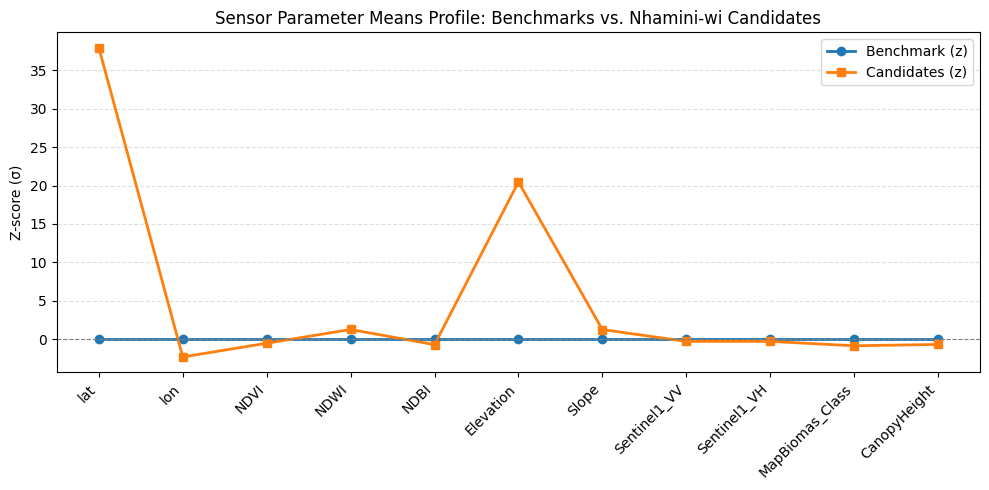

In [6]:
# compare.py

import numpy as np
import matplotlib.pyplot as plt

sensor_cols = [col for col in df_benchmark.columns if df_benchmark[col].dtype != object]

# Select only sensors with valid values in at least one group
valid_cols = [
    col for col in sensor_cols
    if (df_benchmark[col].notna().any() and df_candidates[col].notna().any())
]

coverage = (df_candidates[valid_cols].notna().sum() / len(df_candidates)).round(2)
print("Proportion of valid values ​​in each sensor (candidates):")
print(coverage)

# --- Explicit comparison explanation ---
print("\n[INFO] The following plot and statistics provide a direct comparison between the environmental parameters of known archaeological benchmarks and the new candidates.\n"
      "The Z-score profile plot visualizes how similar or different the candidates are from the benchmarks for each sensor.\n"
      "Use this to identify which candidates most closely resemble known sites, or which parameters stand out as anomalous.")

z_bench = (df_benchmark[valid_cols] - df_benchmark[valid_cols].mean()) \
          / df_benchmark[valid_cols].std()

z_cand  = (df_candidates[valid_cols] - df_benchmark[valid_cols].mean()) \
          / df_benchmark[valid_cols].std()

means_bench = z_bench.mean().values
means_cand  = z_cand.mean().values

x = np.arange(len(valid_cols))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, means_bench, marker='o', label='Benchmark (z)', linewidth=2)
ax.plot(x, means_cand, marker='s', label='Candidates (z)', linewidth=2)

ax.set_ylabel("Z-score (σ)")
ax.set_title('Sensor Parameter Means Profile: Benchmarks vs. Nhamini-wi Candidates')
ax.set_xticks(x)
ax.set_xticklabels(valid_cols, rotation=45, ha='right')
ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### AI Assessment: Insights from the Digital Expedition

Armed with all these layers of data, I turned again to AI—not just to propose locations, but to evaluate the evidence. Feeding the summarized results and sensor comparisons into the model, I asked for an expert assessment:
Do any of these Nhamini-wi areas stand out as genuine archaeological anomalies? Where does the digital evidence most closely echo the marks of ancient hands?

In [7]:
# analyze-candidates-data.py

from openai import OpenAI
import os
import pandas as pd
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    openai_key = user_secrets.get_secret("openai")
except Exception:
    openai_key = os.environ.get("OPENAI_API_KEY")
from pydantic import BaseModel
try:
    from IPython.display import display
except ImportError:
    display = None

# Generates the mean summary for all benchmark sensors
def generate_sensor_summary(df, label):
    lines = [f"{label} stats (mean):"]
    for col in df.columns:
        if df[col].dtype != object:
            val = df[col].mean()
            lines.append(f"{col}: {val:.3f}")
    return "\n".join(lines)

# Generates a detailed summary for all candidates
def generate_candidates_detail(df):
    lines = ["Candidates:"]
    for idx, row in df.iterrows():
        vals = []
        for col in df.columns:
            if df[col].dtype != object:
                vals.append(f"{col}: {row[col]:.3f}")
            else:
                vals.append(f"{col}: {row[col]}")
        lines.append("- " + ", ".join(vals))
    return "\n".join(lines)

summary_bench = generate_sensor_summary(df_benchmark, "Benchmark")
summary_cand = generate_candidates_detail(df_candidates)
summary = f"{summary_bench}\n\n{summary_cand}"

prompt = (
    "You are an expert in Amazonian remote sensing and archaeology.\n"
    "Below are summarized environmental parameters for known archaeological sites (benchmarks) and for new candidate locations along the Nhamini-wi trail.\n"
    "Based on this data, compare the candidates to the benchmarks and assess:\n"
    "- Which, if any, of the candidates most closely match the benchmarks?\n"
    "- Are there anomalies or promising signals in the candidate data that warrant field investigation?\n"
    "- Briefly explain the key differences and what they might mean archaeologically.\n"
    "Be concise and analytical, referencing the key parameters (NDVI, NDWI, NDBI, SRTM, slope, Sentinel-1 radar, land cover, canopy height, etc.).\n"
    "Return ONLY a JSON object with a 'matches' key, which is a list of the closest candidate(s) to the benchmarks. Each match must have: name, lat, lon, reason. If none, return an empty list.\n"
    f"\n{summary}\n"
)
    # Defines the schema for Structured Outputs
schema = {
    "type": "object",
    "properties": {
        "matches": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "name":   {"type": "string"},
                    "lat":    {"type": "number"},
                    "lon":    {"type": "number"},
                    "reason": {"type": "string"}
                },
                "required": ["name", "lat", "lon", "reason"],
                "additionalProperties": False
            }
        }
    },
    "required": ["matches"],
    "additionalProperties": False
}

# --- Structured Output with Pydantic ---
client = OpenAI(api_key=openai_key) if openai_key else OpenAI()

class ClosestMatch(BaseModel):
    name: str
    lat: float
    lon: float
    reason: str

class ClosestMatches(BaseModel):
    matches: list[ClosestMatch]

model_name = "o3"
response = client.responses.parse(
    model=model_name,
    input=[{"role": "user", "content": prompt}],
    text_format=ClosestMatches,
)

matches = response.output_parsed.matches

# Print model version used
print(f"\n[INFO] OpenAI model used: {model_name}")

print("\nMatches:")
for m in matches:
    print(f"- {m.name} (lat: {m.lat}, lon: {m.lon})\n  Reason: {m.reason}\n")

# Display the result as a DataFrame in Kaggle/notebook environments (optional)

import pandas as pd

# Ensure full text is shown in the 'reason' column (rationale)
pd.set_option('display.max_colwidth', None)

df_matches = pd.DataFrame([m.model_dump() for m in matches])
try:
    from IPython.display import display
    display(df_matches)
except Exception:
    print(df_matches)

# Display usage information safely (as in search-candidates.py)
usage = getattr(response, "usage", None)
try:
    print("\nPrompt tokens:", getattr(usage, "prompt_tokens", getattr(usage, "input_tokens", None)))
    print("Completion tokens:", getattr(usage, "completion_tokens", getattr(usage, "output_tokens", None)))
    print("Total tokens:", getattr(usage, "total_tokens", None))
except Exception:
    print("\nUsage info:", usage)


[INFO] OpenAI model used: o3

Matches:
- Upper Pira-Paraná mesa (lat: 1.233, lon: -69.483)
  Reason: Closest overall numerical fit: NDVI (+0.08), NDWI (+0.04), NDBI (-0.14), elevation (+5 m), slope (+0.8°) and Sentinel-1 VV/VH (<0.3 dB) all near benchmark means; canopy only 2 m lower. Minor land-cover class disparity (3 vs 7) may reflect intact terra-firme forest masking past occupation—promising for field verification.

- Serra do Traíra ridge (lat: 0.722, lon: -67.742)
  Reason: Second-closest: spectral indices and radar very similar, slope virtually identical; elevation 40 m lower and canopy 3 m shorter but still within natural variability. Strongly negative NDBI suggests buried cultural soils beneath mature forest; mythic link and lack of survey make it worthy of ground truthing.



,name,lat,lon,reason
0,Upper Pira-Paraná mesa,1.233,-69.483,"Closest overall numerical fit: NDVI (+0.08), NDWI (+0.04), NDBI (-0.14), elevation (+5 m), slope (+0.8°) and Sentinel-1 VV/VH (<0.3 dB) all near benchmark means; canopy only 2 m lower. Minor land-cover class disparity (3 vs 7) may reflect intact terra-firme forest masking past occupation—promising for field verification."
1,Serra do Traíra ridge,0.722,-67.742,"Second-closest: spectral indices and radar very similar, slope virtually identical; elevation 40 m lower and canopy 3 m shorter but still within natural variability. Strongly negative NDBI suggests buried cultural soils beneath mature forest; mythic link and lack of survey make it worthy of ground truthing."



Prompt tokens: 2877
Completion tokens: 1955
Total tokens: 4832


### Seeing the Unseen: Visualizing the Candidate Site

Numbers and parameters told part of the story, but satellite images allow us to see the landscape much as an explorer might—from above, with the forest and rivers laid out like clues on a map. To better understand the chosen candidate site, I generated a series of satellite visualizations, each revealing a different aspect of the terrain.

True-color imagery offers a window into the present-day canopy, while infrared and NDVI composites highlight patterns of vegetation and possible traces of past human activity. Water indices (NDWI) expose subtle changes in soil moisture, and radar imagery from Sentinel-1 allows us to pierce through clouds, mapping surface structure even during the Amazon’s rainy season.

By layering these distinct “views from above,” I could build a richer picture of what might lie hidden beneath the trees—bringing together science, legend, and the raw power of remote sensing.


[INFO] Generating images for: Upper Pira-Paraná mesa (lat: 1.233, lon: -69.483)
[INFO] Using dataset_id: COPERNICUS/S2_SR_HARMONIZED (Sentinel-2) for RGB, Infrared (NIR), NDVI, NDWI
[INFO] Using dataset_id: COPERNICUS/S1_GRD (Sentinel-1) for Sentinel-1 VV
[INFO] Using dataset_id: COPERNICUS/S1_GRD (Sentinel-1) for Sentinel-1 VV


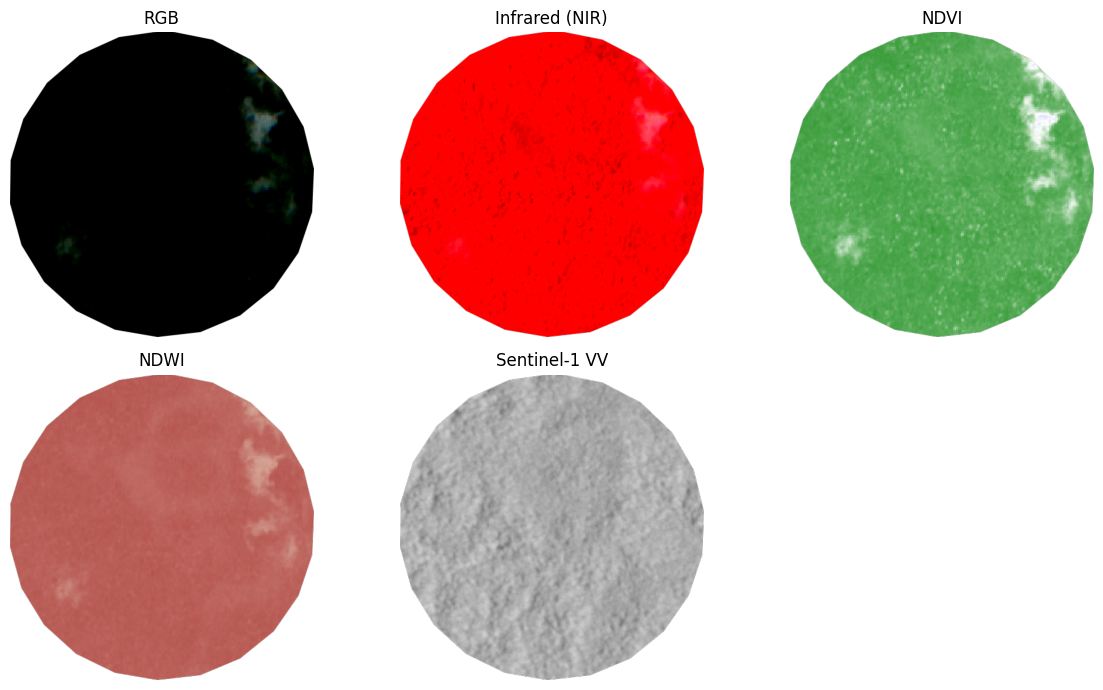


[INFO] Generating images for: Serra do Traíra ridge (lat: 0.722, lon: -67.742)
[INFO] Using dataset_id: COPERNICUS/S2_SR_HARMONIZED (Sentinel-2) for RGB, Infrared (NIR), NDVI, NDWI
[INFO] Using dataset_id: COPERNICUS/S1_GRD (Sentinel-1) for Sentinel-1 VV
[INFO] Using dataset_id: COPERNICUS/S1_GRD (Sentinel-1) for Sentinel-1 VV


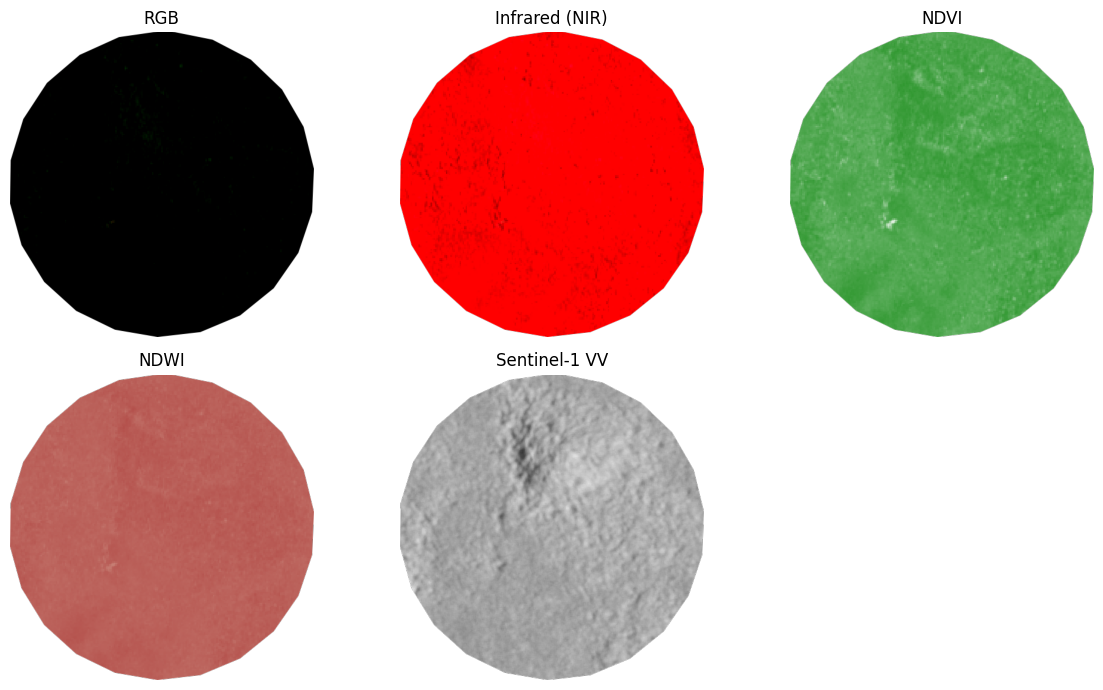

In [8]:
# get-image-for-matches.py

def plot_multiple_satellite_views(lat, lon, buffer_m=1000, year=2023):
    point = ee.Geometry.Point(lon, lat).buffer(buffer_m)
    print("[INFO] Using dataset_id: COPERNICUS/S2_SR_HARMONIZED (Sentinel-2) for RGB, Infrared (NIR), NDVI, NDWI")
    img = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(point)
           .filterDate(f'{year}-01-01', f'{year}-12-31')
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
           .median().clip(point))
    # URLs for each composite
    urls = {}
    urls['RGB'] = img.select(['B4', 'B3', 'B2']).getThumbURL({
        'region': point, 'dimensions': 512, 'min': 500, 'max': 2500})
    urls['Infrared (NIR)'] = img.select(['B8', 'B4', 'B3']).getThumbURL({
        'region': point, 'dimensions': 512, 'min': 500, 'max': 2500})
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    urls['NDVI'] = ndvi.getThumbURL({
        'region': point, 'dimensions': 512, 'min': 0, 'max': 1,
        'palette': ['blue', 'white', 'green']})
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
    urls['NDWI'] = ndwi.getThumbURL({
        'region': point, 'dimensions': 512, 'min': -1, 'max': 1,
        'palette': ['brown', 'beige', 'blue']})
    print("[INFO] Using dataset_id: COPERNICUS/S1_GRD (Sentinel-1) for Sentinel-1 VV")
    # Sentinel-1 VV
    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(point) \
        .filterDate(f'{year}-01-01', f'{year}-12-31') \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select('VV')
    s1_img = s1.median().clip(point)
    urls['Sentinel-1 VV'] = s1_img.getThumbURL({
        'region': point, 'dimensions': 512, 'min': -25, 'max': 0,
        'palette': ['black', 'white']})
    # Plot all images
    import requests
    from PIL import Image
    from io import BytesIO
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 7))
    for i, (name, url) in enumerate(urls.items()):
        response = requests.get(url)
        im = Image.open(BytesIO(response.content))
        plt.subplot(2, 3, i+1)
        plt.imshow(im)
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage for all matches using the in-memory df_matches DataFrame:
import pandas as pd
# Log dataset ID if available in df_matches
if 'df_matches' in globals() and df_matches is not None and not df_matches.empty:
    dataset_id = None
    # Try to get dataset_id from DataFrame attribute or column
    if hasattr(df_matches, 'dataset_id'):
        dataset_id = getattr(df_matches, 'dataset_id', None)
    elif 'dataset_id' in df_matches.columns:
        dataset_id = df_matches['dataset_id'].iloc[0]
    if dataset_id:
        print(f"[INFO] Using dataset_id: {dataset_id}")
    for _, m in df_matches.iterrows():
        print(f"\n[INFO] Generating images for: {m['name']} (lat: {m['lat']}, lon: {m['lon']})")
        plot_multiple_satellite_views(m['lat'], m['lon'], buffer_m=1000, year=2023)
else:
    print("No match found to generate images.")

## Leveraging Candidate Analysis for Future Discoveries
The candidate sites identified and analyzed in this notebook are not only useful for the current comparison with known archaeological benchmarks, but also serve as a valuable resource for future research and fieldwork.

**How to use these results for future discoveries:**

1. **Re-prompting and Iterative Analysis:**
   - The list of candidate sites (with their environmental parameters and model rationales) can be used as input for new prompts or models, enabling iterative refinement and prioritization as new data or hypotheses emerge.
3. **Integration with New Datasets:**
   - As additional remote sensing layers or ground-truth data become available, these candidates can be re-evaluated or enriched, helping to identify new patterns or confirm archaeological potential.
4. **Fieldwork Planning:**
   - The coordinates, bounding boxes, and rationales for each candidate can directly inform field survey planning, allowing teams to focus on the most promising or anomalous locations.
6. **Reproducibility and Collaboration:**
   - By maintaining a structured, notebook-friendly DataFrame of candidates, all steps and decisions are transparent and reproducible, facilitating collaboration and further analysis by other researchers.

**Tip:**
You can always re-use the `df_matches` DataFrame as input for new analyses, visualizations, or as a filter for satellite image extraction and further model runs.

## Project Structure

### 1. Benchmark Site Generation (`benchmark.py`)
- Uses OpenAI's o3 model to generate a list of known archaeological sites in Acre, Brazil
- Focuses on geoglyphs and earthworks documented in academic literature
- Creates a reference dataset with coordinates (latitude/longitude) for comparison
- Outputs data in both CSV format and formatted tables
  
### 2. Authentication (`auth.py`)
- Authenticates with Google Earth Engine using service account credentials
- Retrieves API keys from Kaggle Secrets for security
- Sets up the connection to Earth Engine services

### 3. Remote Sensing Data Collection (`get-benchmark-data.py`)
This is the core module that enriches location data with multiple satellite sensors:

#### Environmental Parameters Collected:
- **NDVI (Normalized Difference Vegetation Index)** - Vegetation health indicator
- **NDWI (Normalized Difference Water Index)** - Water content and moisture
- **NDBI (Normalized Difference Built-up Index)** - Built environment detection
- **SRTM Elevation & Slope** - Topographical characteristics
- **Sentinel-1 Radar (VV/VH)** - Penetrates vegetation to detect subsurface features
- **MapBiomas Land Cover Classification** - Land use classification
- **GEDI Canopy Height** - Forest canopy structure from LiDAR

#### Data Sources:
- Sentinel-2 optical imagery (Copernicus program)
- Sentinel-1 synthetic aperture radar
- SRTM digital elevation model
- MapBiomas Pan-Amazon land cover data
- GEDI (Global Ecosystem Dynamics Investigation) LiDAR

### 4. Candidate Site Discovery (`search-candidates.py`)
- Uses AI to suggest promising but underexplored locations in the Nhamini-wi region
- Based on historical legends, indigenous oral history, and expedition records
- Generates hypothetical coordinates for areas that warrant archaeological investigation
- Provides rationale for each suggested location
- **Each candidate footprint includes a center (latitude/longitude) and a fixed radius (e.g., 500m), allowing representation as a circle or bounding box (bbox/WKT) for spatial analysis, as required by the OpenAI to Z Challenge.**

### 5. Candidate Data Processing (`get-candidates-data.py`)
- Applies the same remote sensing analysis to candidate locations
- Creates comparable datasets between known sites and potential discoveries

### 6. Comparative Analysis (`compare.py`)
- Performs statistical comparison between benchmark sites and candidate locations
- Normalizes sensor data using z-scores for fair comparison
- Creates visualization plots showing environmental parameter profiles
- Identifies which candidates most closely match known archaeological sites

### 7. AI-Powered Site Assessment (`analyze-candidates-data.py`)
- Uses OpenAI's o3 model to analyze environmental data patterns
- Compares candidate sites against benchmark archaeological sites
- Provides expert-level interpretation of remote sensing anomalies
- Outputs JSON-formatted results with closest matches and archaeological significance

### 8. Satellite Imagery Visualization (`get-image-for-closest-match.py`)
- Generates multi-spectral satellite views of promising locations
- Creates composite images including:
  - True color RGB
  - Near-infrared false color
  - NDVI vegetation index
  - NDWI water index
  - Sentinel-1 radar backscatter
- Provides visual inspection capabilities for identified sites

## Methodology

### Remote Sensing Approach
The project employs a multi-sensor approach to characterize archaeological sites:
1. **Optical sensors** detect vegetation anomalies and surface features
2. **Radar sensors** penetrate forest canopy to reveal subsurface structures
3. **LiDAR data** provides precise elevation and canopy measurements
4. **Land cover data** identifies human-modified landscapes

### AI Integration
- **Site Discovery**: AI generates hypotheses about unexplored locations based on historical and cultural knowledge
- **Pattern Recognition**: Machine learning identifies environmental signatures of known archaeological sites
- **Expert Analysis**: AI provides archaeological interpretation of remote sensing anomalies

### Statistical Analysis
- Z-score normalization enables comparison across different sensor types
- Pattern matching identifies candidate sites with similar environmental signatures to known archaeological locations

## Applications
- **Archaeological Survey Planning**: Prioritizes areas for field investigation
- **Cultural Heritage Protection**: Identifies sites at risk from deforestation or development
- **Indigenous Territory Mapping**: Documents traditional landscapes and settlement patterns
- **Environmental Archaeology**: Studies human-environment interactions in the Amazon

## Technical Requirements
- Google Earth Engine account with API access
- OpenAI API key (o3 model access)
- Python environment with geospatial libraries
- Kaggle environment for secure credential management

## Data Outputs
- DataFrame with enriched location data
- Comparative analysis plots
- Satellite imagery composites
- JSON reports with archaeological assessments
- Prioritized lists of sites for field verification

This project demonstrates the integration of artificial intelligence with remote sensing technology for archaeological discovery in one of the world's most challenging environments - the Amazon rainforest.

## Github
Access the full GitHub project [here](https://github.com/giovannicocco/openai-z-challenge), which includes an additional example of using OpenAI Agents with Function Calling and Structured Outputs.

---
## Limitations and Next Steps
> **Limitations:**
- Dependence on open data and sensor coverage may limit the detection of micro-sites or structures under dense canopy.
- The automated approach does not replace field validation and traditional Indigenous knowledge.
- Possible biases in historical data and consulted literature.

> **Next Steps:**
- Integrate ethnographic data and crowdsourced local reports.
- Explore multimodal AI models for analysis of historical images and texts.
- Expand the analysis to other regions of the Amazon and compare patterns.

---
## Further Reading and Resources
- [Archaeology in the Amazon: Recent Discoveries](https://www.nature.com/articles/d41586-018-07287-2)
- [MapBiomas Project](https://mapbiomas.org/)
- [GEDI NASA Mission](https://gedi.umd.edu/)
- [OpenAI Function Calling](https://platform.openai.com/docs/guides/function-calling)
- [Folium Interactive Maps](https://python-visualization.github.io/folium/)
- [Indigenous Knowledge and Remote Sensing](https://www.sciencedirect.com/science/article/pii/S2351989422000132)

## Knowing issues 

Sometimes Google Earth Engine returns a 500 error. If this happens, simply try running the cell again.